In [16]:
#Import all required ML library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA




               Date  Transaction Count
0  01-01-2016 00:00            2093576
1  02-01-2016 00:00            2397260
2  03-01-2016 00:00            2173039
3  04-01-2016 00:00            2051240
4  05-01-2016 00:00            1954117
(1285, 2)


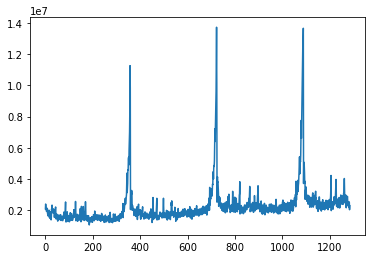

In [17]:

#Load the CSV file
df = pd.read_csv('GC-Traffic.csv', header=0)
#Print the file header that is date and transaction count
print(df.head())
#Print the dimesnion of file , it has two dimesnions , date and time
print(df.shape)
#print the transaction count only , on X axist it is the row index of transaction count in the file
plt.plot(df["Transaction Count"])
plt.show()


In [18]:

## Check whether time series is stationary
##First difference (period-to-period change) Statistical stationarity: A stationary time series 
##is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.
## Note : If Time series is stationary then Auto regression model can be applied
## Auto Regressive Model :  y(t) = δ + φ1yt-1 + φ2yt-2 + … + φpyt-1 + c

X = df["Transaction Count"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
else:
    print ("Time Series is Non-Stationary")


ADF Statistic: -5.502094
p-value: 0.000002
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Time Series is Stationary


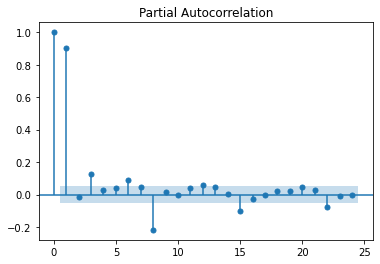

In [19]:
##  Auto Regression works based on Lag , how many previuous time series (TN-1 , TN-2..) need to be considered to 
##calculate the TNth value. Based on outcome , as shown in diagram below , comparing the variation with previous time (TN-1)
## is sufficient to caluclate the auto regression. This is basically Lag 1 OR Auto regression 1 problem
## y(t) = δ + φ1yt-1 +c , so basically need to find out  δ , φ1 and constant c value. To calculate δ and φ1 use
## use of Linear Regression is requitred
plot_pacf(X, lags=24);

In [20]:
##  Lets proceed for Linear Regression Model
##Use Panda function "shift" to find out "yt-1"
## in the diagram below Transaction Count_Shifted is value for "yt-1"
df["Transaction Count_shifted"]  = df["Transaction Count"].shift()
df.head()



,Date,Transaction Count,Transaction Count_shifted
0,01-01-2016 00:00,2093576,NaN
1,02-01-2016 00:00,2397260,2093576.0
2,03-01-2016 00:00,2173039,2397260.0
3,04-01-2016 00:00,2051240,2173039.0
4,05-01-2016 00:00,1954117,2051240.0


In [21]:
## Drop Date column to cretae Linear regression model
df.drop('Date', axis = 1, inplace=True)
#drop the Nan value
## Value "Transaction count" is value at yt and "Transaction Count_shifted" is value at "yt-1"
df.dropna(inplace=True)
df.head()


,Transaction Count,Transaction Count_shifted
1,2397260,2093576.0
2,2173039,2397260.0
3,2051240,2173039.0
4,1954117,2051240.0
5,1923592,1954117.0


In [22]:
## Split features and target into y and x
## y is values of y at t
## x is value of y at t-1
y = df["Transaction Count"].values
X = df["Transaction Count_shifted"].values

## train on 80% of data and validate on 20% of data
train_size = int(len(X) * 0.80)

## Now split the data.
## time series model requires taining and testing data to continous in nature , you can't have random test data
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

## Since train and test has only one column of data and so to avoid error  change the dimesnion to 1 with dummy -1
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
lr = LinearRegression()
lr.fit(X_train, y_train)
## Here is coefficient value and intercept value that is va;ue of 
##  δ and φ1  in formula y(t) = δ + φ1yt-1
lr.coef_
print("Coefficient value is :" ,lr.coef_)
lr.intercept_
print("Intercept value is :" ,lr.intercept_)


Coefficient value is : [0.88892981]
Intercept value is : 226842.1416496532


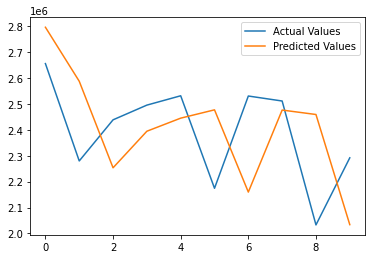

In [23]:
## Now predict the value
y_pred = lr.predict(X_test)
#print(y_pred)
#use Linear Regression Model
# compare actual and prediction for last 10 data in series set
plt.plot(y_test[-10:], label="Actual Values")
plt.plot(y_pred[-10:], label="Predicted Values")
plt.legend()
plt.show()

Data values are :  [2093576. 2397260. 2173039. ... 2530250. 2510980. 2032842.]
Root Mean Square Error : 744704.849


c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


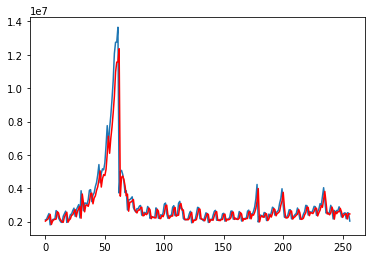

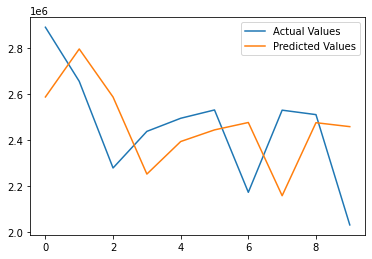

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1027
Model:                     AutoReg(1)   Log Likelihood              -14860.275
Method:               Conditional MLE   S.D. of innovations         472012.144
Date:                Sun, 30 Aug 2020   AIC                             26.135
Time:                        15:58:37   BIC                             26.150
Sample:                             1   HQIC                            26.141
                                 1027                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.268e+05   3.27e+04      6.933      0.000    1.63e+05    2.91e+05
y.L1           0.8889      0.014     62.164      0.000       0.861       0.917
                                    Roots           

In [24]:
# Use time series modle Auto Regression

# Declare a method Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

## Load the data
series = pd.read_csv('GC-Traffic.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# Use shifted data to split dataset
X = df["Transaction Count_shifted"].values ##difference(series.values)
print("Data values are : ",X)

# Use 80 % data for train and 20 % data for testing
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:]

# train autoregression
model = AutoReg(train, lags=1)
model_fit = model.fit()

## Here is coefficient of the Auto Regression model
coef = model_fit.params

# Now preidct the data and compare with test data
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)


## Print the root mean square error of the model
rmse = sqrt(mean_squared_error(test, predictions))
print('Root Mean Square Error : %.3f' % rmse)

# plot test data for full test data
plt.plot(test)
# plot predicted data for full data
plt.plot(predictions, color='red')
plt.show()

# plot test data for last 10 data in test data
plt.plot(test[-10:], label="Actual Values")
# plot predicted data for last 10 data in test data
plt.plot(predictions[-10:], label="Predicted Values")
plt.legend()
plt.show()

## Print model summary
print(model_fit.summary())